# Transfer learning and fine-tuning

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import PIL

## Data preprocessing

### Data download

In [11]:
!git clone https://github.com/jacgold54/image_classification.git images
train_dir = os.path.join('images/train')

BATCH_SIZE = 64
IMG_SIZE = (224, 224)
validation_split = 0.2
seed_train_validation = 1
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE,
                                                            seed = seed_train_validation,
                                                            label_mode = "categorical",
                                                            validation_split = validation_split,
                                                            subset = "training")
validation_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE,
                                                                 seed = seed_train_validation,
                                                                 label_mode = "categorical",
                                                                 validation_split = validation_split,
                                                                 subset = "validation")

fatal: destination path 'images' already exists and is not an empty directory.
Found 6982 files belonging to 101 classes.
Using 5586 files for training.
Found 6982 files belonging to 101 classes.
Using 1396 files for validation.


In [12]:
test_dir = os.path.join('images/test')
test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE,
                                                            label_mode = "categorical")

Found 1695 files belonging to 101 classes.


In [15]:
test_img_1 = tf.keras.utils.load_img(
    'images/IMG_7945.jpg',
    color_mode="rgb",
    target_size=IMG_SIZE,
    interpolation="nearest",
    keep_aspect_ratio=False,
)
test_img_1.show()
test_img_1=test_img_1.rotate(270, PIL.Image.NEAREST, expand = 1)
test_img_1.show()
test_img_1 = tf.keras.utils.img_to_array(test_img_1)
test_img_2 = tf.keras.utils.load_img(
    'images/IMG_7946.jpg',
    color_mode="rgb",
    target_size=IMG_SIZE,
    interpolation="nearest",
    keep_aspect_ratio=False,
)
test_img_2=test_img_2.rotate(270, PIL.Image.NEAREST, expand = 1)
test_img_2 = tf.keras.utils.img_to_array(test_img_2)
test_img_3 = tf.keras.utils.load_img(
    'images/IMG_7949.jpg',
    color_mode="rgb",
    target_size=IMG_SIZE,
    interpolation="nearest",
    keep_aspect_ratio=False,
)
test_img_3=test_img_3.rotate(270, PIL.Image.NEAREST, expand = 1)
test_img_3 = tf.keras.utils.img_to_array(test_img_3)

Show the first nine images and labels from the training set:

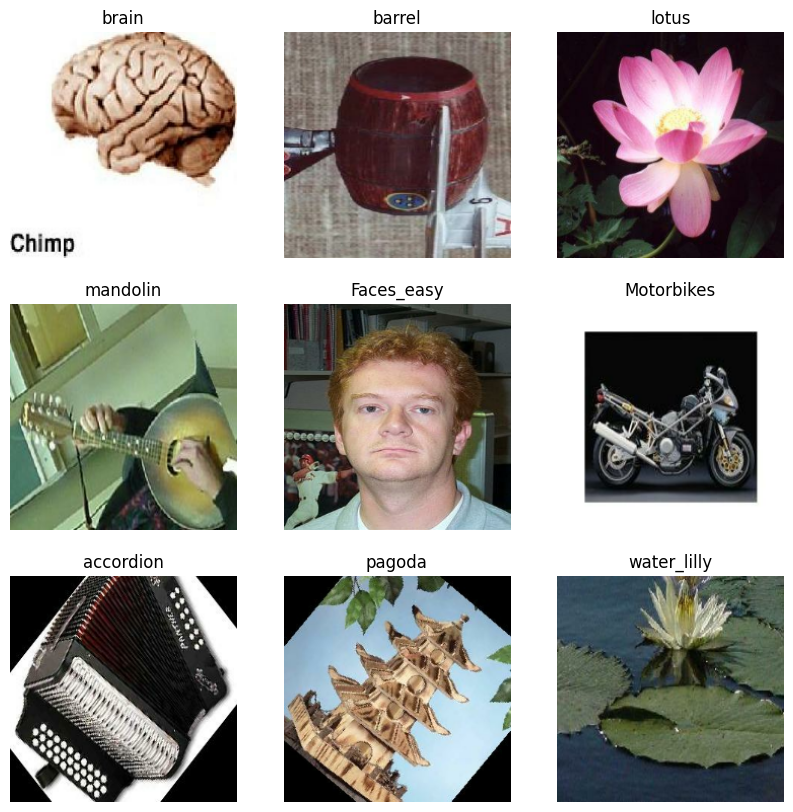

In [16]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis("off")

In [10]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of training batches: %d' % tf.data.experimental.cardinality(train_dataset))

Number of validation batches: 18
Number of training batches: 88


### Configure the dataset for performance

In [17]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
#test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### Use data augmentation

In [18]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

Let's repeatedly apply these layers to the same image and see the result.

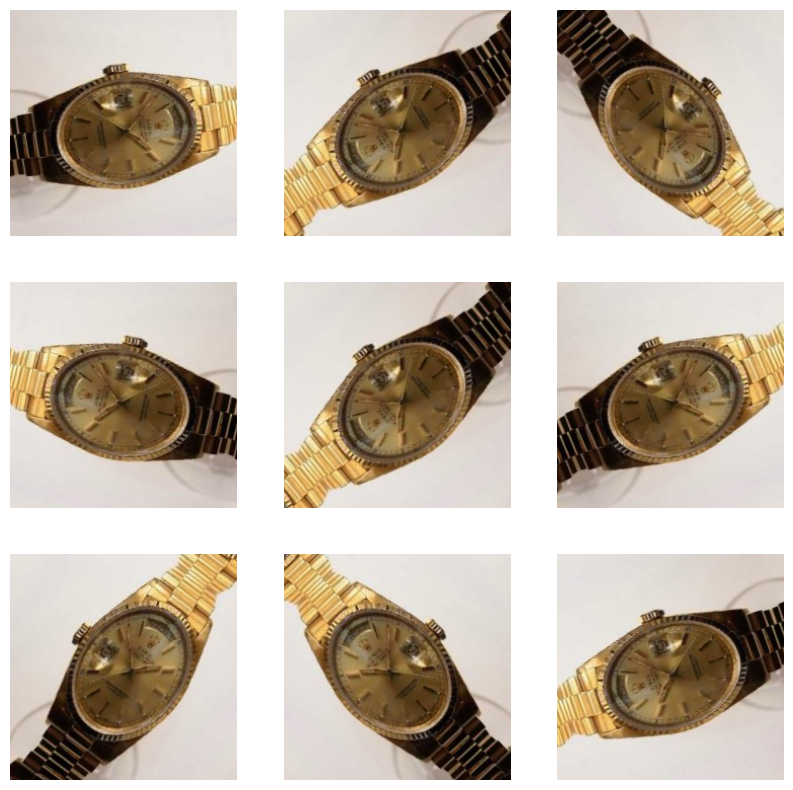

In [19]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [20]:
preprocess_input = tf.keras.applications.resnet50.preprocess_input

Note: Alternatively, you could rescale pixel values from `[0, 255]` to `[-1, 1]` using `tf.keras.layers.Rescaling`.

In [21]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

Note: If using other `tf.keras.applications`, be sure to check the API doc to determine if they expect pixels in `[-1, 1]` or `[0, 1]`, or use the included `preprocess_input` function.

In [62]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

This feature extractor converts each `160x160x3` image into a `5x5x1280` block of features. Let's see what it does to an example batch of images:

In [63]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(64, 7, 7, 2048)


In [64]:
base_model.trainable = False

In [25]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

### Add a classification head

To generate predictions from the block of features, average over the spatial `5x5` spatial locations, using a `tf.keras.layers.GlobalAveragePooling2D` layer to convert the features to  a single 1280-element vector per image.

In [65]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(64, 2048)


Apply a `tf.keras.layers.Dense` layer to convert these features into a single prediction per image. You don't need an activation function here because this prediction will be treated as a `logit`, or a raw prediction value. Positive numbers predict class 1, negative numbers predict class 0.

In [66]:
prediction_layer = tf.keras.layers.Dense(101, activation = 'softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(64, 101)


Build a model by chaining together the data augmentation, rescaling, `base_model` and feature extractor layers using the [Keras Functional API](https://www.tensorflow.org/guide/keras/functional). As previously mentioned, use `training=False` as our model contains a `BatchNormalization` layer.

In [67]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
#x = tf.keras.layers.Dense(1024)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

### Compile the model

Compile the model before training it. Since there are two classes, use the `tf.keras.losses.BinaryCrossentropy` loss with `from_logits=True` since the model provides a linear output.

In [68]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

In [69]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_2  (None, 224, 224, 3)       0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_2 (TFOpLamb  (None, 224, 224, 3)       0         
 da)                                                             
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0   

The 2.5 million parameters in MobileNet are frozen, but there are 1.2 thousand _trainable_ parameters in the Dense layer. These are divided between two `tf.Variable` objects, the weights and biases.

In [70]:
print(model.trainable_variables)

[<tf.Variable 'dense_1/kernel:0' shape=(2048, 101) dtype=float32, numpy=
array([[ 0.00407436,  0.00246597, -0.0043486 , ...,  0.02434905,
         0.04190161, -0.03120844],
       [-0.04942078,  0.03856206, -0.03802081, ...,  0.02639486,
        -0.01944464, -0.03906073],
       [-0.0518299 , -0.00138437, -0.01901188, ...,  0.03258686,
        -0.02330366, -0.01144318],
       ...,
       [-0.01649031, -0.03675389, -0.03930291, ..., -0.04512507,
         0.01745212, -0.03619209],
       [ 0.0493844 , -0.02738749, -0.02615126, ...,  0.00115351,
         0.00730063,  0.01163689],
       [ 0.03414027, -0.01857217,  0.02919681, ..., -0.01686161,
        -0.00832554,  0.03388259]], dtype=float32)>, <tf.Variable 'dense_1/bias:0' shape=(101,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       

### Train the model

After training for 10 epochs, you should see ~94% accuracy on the validation set.


In [71]:
initial_epochs = 100

loss0, accuracy0 = model.evaluate(validation_dataset)

22/22 [==============================] - 4s 104ms/step - loss: 5.4182 - accuracy: 0.0158


In [72]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 5.42
initial accuracy: 0.02


In [73]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/100
88/88 [==============================] - 17s 157ms/step - loss: 4.2760 - accuracy: 0.1445 - val_loss: 3.3465 - val_accuracy: 0.2837
Epoch 2/100
88/88 [==============================] - 14s 157ms/step - loss: 2.9143 - accuracy: 0.3554 - val_loss: 2.3776 - val_accuracy: 0.4878
Epoch 3/100
88/88 [==============================] - 14s 157ms/step - loss: 2.1225 - accuracy: 0.5088 - val_loss: 1.7672 - val_accuracy: 0.6354
Epoch 4/100
88/88 [==============================] - 14s 157ms/step - loss: 1.6353 - accuracy: 0.6300 - val_loss: 1.3749 - val_accuracy: 0.7307
Epoch 5/100
88/88 [==============================] - 14s 157ms/step - loss: 1.3217 - accuracy: 0.7009 - val_loss: 1.1131 - val_accuracy: 0.7808
Epoch 6/100
88/88 [==============================] - 14s 157ms/step - loss: 1.0771 - accuracy: 0.7614 - val_loss: 0.9340 - val_accuracy: 0.8195
Epoch 7/100
88/88 [==============================] - 14s 158ms/step - loss: 0.9196 - accuracy: 0.7991 - val_loss: 0.8023 - val_accuracy:

### Learning curves

Let's take a look at the learning curves of the training and validation accuracy/loss when using the MobileNetV2 base model as a fixed feature extractor.

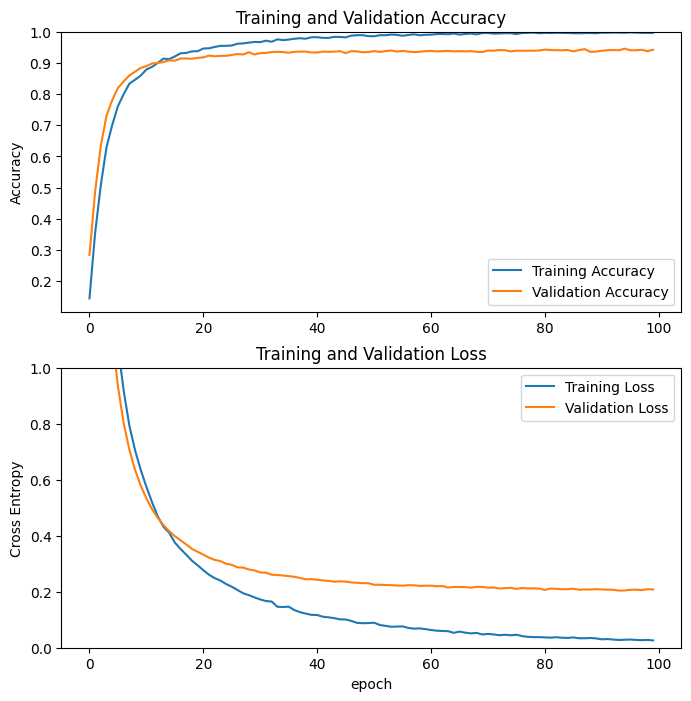

In [74]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Un-freeze the top layers of the model


In [75]:
base_model.trainable = True

In [76]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  175


### Compile the model

As you are training a much larger model and want to readapt the pretrained weights, it is important to use a lower learning rate at this stage. Otherwise, your model could overfit very quickly.

In [77]:
model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/100),
              metrics=['accuracy'])

In [78]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_2  (None, 224, 224, 3)       0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_2 (TFOpLamb  (None, 224, 224, 3)       0         
 da)                                                             
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0   

In [79]:
len(model.trainable_variables)

92

### Continue training the model

If you trained to convergence earlier, this step will improve your accuracy by a few percentage points.

In [80]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=fine_tune_epochs,
                         validation_data=validation_dataset)

Epoch 1/10
88/88 [==============================] - 30s 228ms/step - loss: 0.0237 - accuracy: 0.9961 - val_loss: 0.2101 - val_accuracy: 0.9391
Epoch 2/10
88/88 [==============================] - 19s 217ms/step - loss: 0.0194 - accuracy: 0.9964 - val_loss: 0.2122 - val_accuracy: 0.9441
Epoch 3/10
88/88 [==============================] - 19s 217ms/step - loss: 0.0160 - accuracy: 0.9973 - val_loss: 0.2135 - val_accuracy: 0.9398
Epoch 4/10
88/88 [==============================] - 19s 216ms/step - loss: 0.0148 - accuracy: 0.9977 - val_loss: 0.2170 - val_accuracy: 0.9405
Epoch 5/10
88/88 [==============================] - 19s 216ms/step - loss: 0.0136 - accuracy: 0.9968 - val_loss: 0.2203 - val_accuracy: 0.9391
Epoch 6/10
88/88 [==============================] - 19s 217ms/step - loss: 0.0125 - accuracy: 0.9973 - val_loss: 0.2234 - val_accuracy: 0.9384
Epoch 7/10
88/88 [==============================] - 19s 217ms/step - loss: 0.0118 - accuracy: 0.9979 - val_loss: 0.2282 - val_accuracy: 0.9413

In [81]:
batches = []
val_batches = []
test_batches = []
for batch in train_dataset.as_numpy_iterator():
  batches.append(batch)
for batch in validation_dataset.as_numpy_iterator():
  val_batches.append(batch)
for batch in test_dataset.as_numpy_iterator():
  test_batches.append(batch)

In [82]:
total = np.zeros((101))
for i in range(len(batches)-1):
  for j in range(64):
    total += batches[i][1][j]
val_total = np.zeros((101))
for i in range(len(val_batches)-1):
  for j in range(64):
    val_total += val_batches[i][1][j]
print(total)
print(val_total)

[276. 280. 122. 518.  38. 506.  23.  24.  29.  40.  34.  23.  81.  55.
  31.  58.  65.  28.  24.  77.  31.  41.  39.  67.  29.  43.  54.  49.
  29.  34.  34.  46.  29.  41.  47.  52.  44.  35.  38.  53.  40.  45.
  32.  20.  24.  33.  65.  62.  26.  33.  55.  55.  22.  39.  56.  71.
  37.  54.  45.  28.  40.  29.  26.  51.  23.  49.  40.  20.  25.  31.
  23.  33.  29.  19.  34.  56.  37.  36.  25.  38.  27.  58.  37.  21.
  42.  27.  58.  43.  41.  23.  53.  31.  56.  47. 156.  22.  44.  19.
  36.  16.  38.]
[ 67.  62.  36. 114.   4. 132.  11.   9.   8.   4.   3.   4.  18.  23.
   4.  10.   7.  12.  11.  21.   7.   7.  10.  17.   9.  12.   5.   7.
  10.   7.   8.   8.  13.  11.   8.   7.   8.   7.  12.  14.  13.   9.
   4.   8.   4.   7.  15.  17.   8.  10.  15.   9.   3.  12.  12.  21.
  11.  11.  18.   5.  13.   6.   6.  19.   3.  12.   4.   7.   7.   7.
   8.   3.  12.   8.  12.  10.  11.   4.   7.  13.   5.  10.   8.   6.
  10.   8.  11.   5.   9.   5.  15.   9.  13.  11.  36.   6.

In [83]:
count = np.zeros((101))
correct = np.zeros((101))
y_pred = []
for j in range(len(test_batches)):
  result = model.predict_on_batch(test_batches[j][0])
  actual = test_batches[j][1].argmax(axis=1)
  pred = result.argmax(axis=1)
  y_pred.extend(pred)
  for i in range(len(pred)):
    count[actual[i]] += 1
    correct[actual[i]] += actual[i] == pred[i]
print(correct / count)
print(count)

[0.98850575 1.         1.         1.         1.         1.
 0.75       0.5        1.         1.         0.88888889 0.66666667
 1.         1.         0.625      0.82352941 0.83333333 1.
 0.625      1.         1.         0.90909091 0.75       0.95238095
 1.         0.84615385 0.78571429 0.92857143 0.7        0.4
 0.90909091 1.         0.8        0.92307692 0.84615385 0.86666667
 0.91666667 1.         1.         0.94117647 0.92307692 1.
 0.88888889 1.         0.83333333 0.9        1.         1.
 1.         0.9        1.         1.         0.83333333 0.83333333
 0.88235294 0.90909091 0.91666667 1.         0.93333333 0.625
 0.61538462 0.625      0.875      1.         0.83333333 1.
 1.         0.28571429 1.         0.88888889 1.         1.
 1.         0.66666667 0.90909091 0.9375     1.         0.77777778
 0.75       0.75       0.85714286 0.8125     0.90909091 0.42857143
 1.         1.         1.         1.         1.         0.85714286
 1.         1.         1.         0.93333333 0.95744681

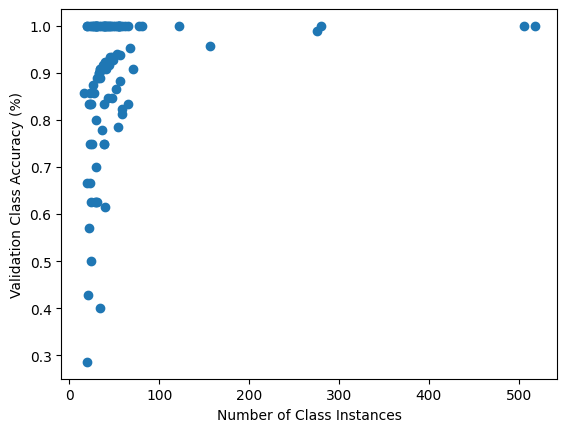

In [84]:
plt.scatter(total,correct / count)
plt.xlabel('Number of Class Instances')
plt.ylabel('Validation Class Accuracy (%)')
plt.show()

In [85]:
print(sum(correct)/sum(count))

0.9321533923303835


In [86]:
y_test = []
y_true = []
for i in range(len(test_batches)):
  for j in range(len(test_batches[i][0])):
    y_test.append(test_batches[i][0][j])
    y_true.append(np.argmax(test_batches[i][1][j]))

In [87]:
import sklearn
c_matrix = sklearn.metrics.confusion_matrix(y_true,y_pred)

AttributeError: module 'sklearn' has no attribute 'metrics'

In [88]:
disp = sklearn.metrics.ConfusionMatrixDisplay(c_matrix)
disp.plot()
plt.show()

AttributeError: module 'sklearn' has no attribute 'metrics'

In [90]:
classes = sorted(os.listdir('images/train'))
classes

['Faces',
 'Faces_easy',
 'Leopards',
 'Motorbikes',
 'accordion',
 'airplanes',
 'anchor',
 'ant',
 'barrel',
 'bass',
 'beaver',
 'binocular',
 'bonsai',
 'brain',
 'brontosaurus',
 'buddha',
 'butterfly',
 'camera',
 'cannon',
 'car_side',
 'ceiling_fan',
 'cellphone',
 'chair',
 'chandelier',
 'cougar_body',
 'cougar_face',
 'crab',
 'crayfish',
 'crocodile',
 'crocodile_head',
 'cup',
 'dalmatian',
 'dollar_bill',
 'dolphin',
 'dragonfly',
 'electric_guitar',
 'elephant',
 'emu',
 'euphonium',
 'ewer',
 'ferry',
 'flamingo',
 'flamingo_head',
 'garfield',
 'gerenuk',
 'gramophone',
 'grand_piano',
 'hawksbill',
 'headphone',
 'hedgehog',
 'helicopter',
 'ibis',
 'inline_skate',
 'joshua_tree',
 'kangaroo',
 'ketch',
 'lamp',
 'laptop',
 'llama',
 'lobster',
 'lotus',
 'mandolin',
 'mayfly',
 'menorah',
 'metronome',
 'minaret',
 'nautilus',
 'octopus',
 'okapi',
 'pagoda',
 'panda',
 'pigeon',
 'pizza',
 'platypus',
 'pyramid',
 'revolver',
 'rhino',
 'rooster',
 'saxophone',
 'sc

1/1 [==============================] - 1s 1s/step
Predicted Label: laptop


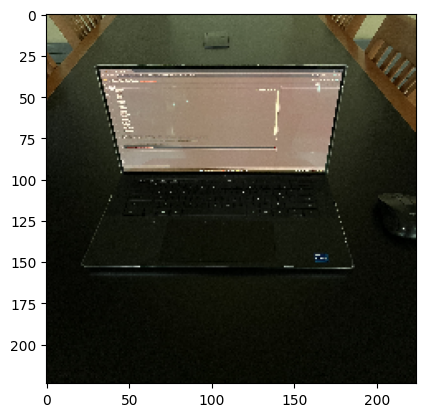

In [91]:
plt.imshow(test_img_1/255)
print("Predicted Label:",classes[np.argmax(model.predict(tf.reshape([test_img_1],(1,224,224,3))))])

1/1 [==============================] - 0s 31ms/step
Predicted Label: chair


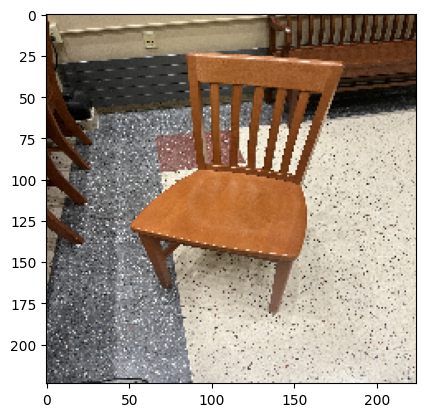

In [92]:
plt.imshow(test_img_2/255)
print("Predicted Label:",classes[np.argmax(model.predict(tf.reshape([test_img_2],(1,224,224,3))))])

1/1 [==============================] - 0s 28ms/step
Predicted Label: Faces


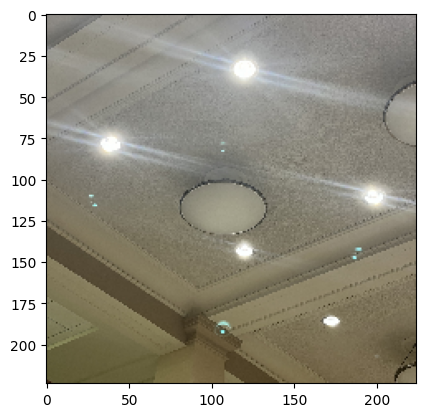

In [93]:
plt.imshow(test_img_3/255)
print("Predicted Label:",classes[np.argmax(model.predict(tf.reshape([test_img_3],(1,224,224,3))))])

In [96]:
model.save_weights("images/hello", overwrite=True)